# OpenPIV examples that you can execute in your browser

In [1]:
# install bleeding edge openpiv-python

# !pip install git+https://github.com/openpiv/openpiv-python

## Import what is necessary from OpenPIV

In [2]:
from openpiv import tools, validation, filters, scaling, pyprocess, preprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from ipywidgets import interact_manual, interactive, fixed, IntSlider, HBox, VBox, Layout

## Read a pair of PIV images

In [3]:
frame_a  = tools.imread( 'particle image 1.bmp' )
frame_b  = tools.imread( 'particle image 2.bmp' )

## Show them using matplotlib

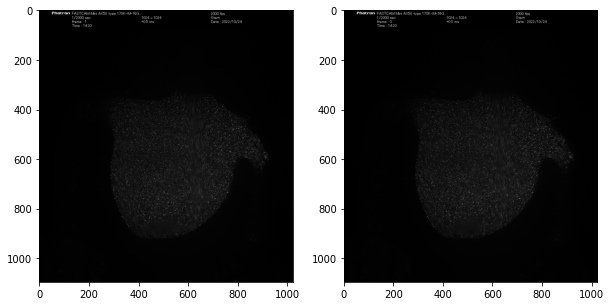

In [4]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)


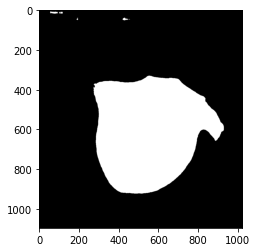

In [5]:
# load the mask
image_mask = tools.imread('mask.bmp')
plt.figure()
plt.imshow(image_mask,cmap='gray')

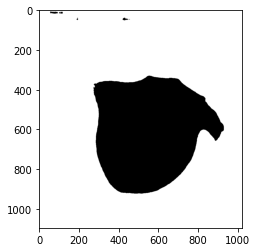

In [6]:
# in OpenPIV we have different convention - mask marks the regions that 
# we do not want to process, these 1 or white regions are "masked" 

image_mask = ~image_mask
plt.figure()
plt.imshow(image_mask,cmap='gray')

In [7]:
# mask images 
frame_a = np.where(image_mask, 0, frame_a)
frame_b = np.where(image_mask, 0, frame_b)

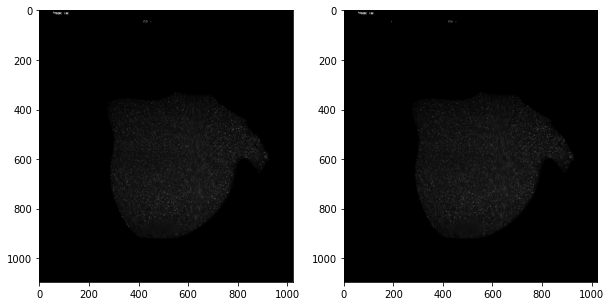

In [8]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_a,cmap='gray')
ax[1].imshow(frame_b,cmap='gray')


## Define the PIV analysis parameters

1. Size of the interrogation window in frame A (winsize), 
2. Size of the search window in frame B (searchsize is larger or equal to winsize), 
3. overlap between the neighbouring windows (overlap), 
4. time interval of the PIV recording ($\Delta t$)
5. type of the peak quality (signal-to-noise ratio)

In [9]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 40  # pixels, search in image B
overlap = 12 # pixels, 50% overlap
dt = 0.02 # sec, time interval between pulses


## Run the OpenPIV (fast code, precompiled in Cython)

In [10]:
u, v, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

## Get a list of coordinates for the vector field

In [11]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

## Clean the peaks that are below a quality threshold

In [12]:
flags = validation.sig2noise_val(sig2noise, threshold = 1.05 )

## Replace those that are masked as bad vectors with local interpolation

In [13]:
# filter out outliers that are very different from the
# neighbours

u, v = filters.replace_outliers( u, v, flags,
                                  method='localmean', 
                                  max_iter=3, 
                                  kernel_size=3)

## Scale the results from pix/dt to mm/sec

In [14]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u, v = scaling.uniform(x, y, u, v, 
                               scaling_factor = 96.52 ) # 96.52 microns/pixel

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u, v = tools.transform_coordinates(x, y, u, v)

In [15]:
# Option 1: manually mask the values

In [16]:
# mask the results on place of flags
u1 = np.where(flags, 0, u)
v1 = np.where(flags, 0, v)

## store the result in a text file

In [17]:
# save in the simple ASCII table format
tools.save('exp1_001.txt', x, y, u1, v1, None, flags)

## plot the data stored in the text file

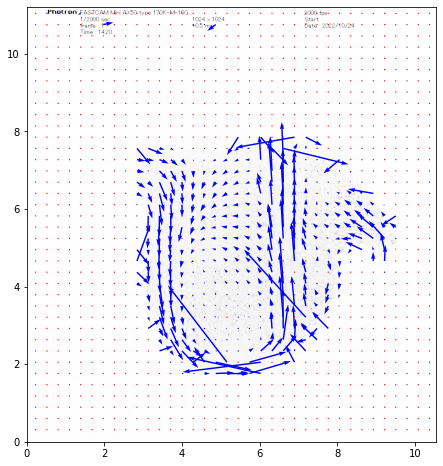

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field('exp1_001.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=50, # scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           image_name='particle image 1.bmp');

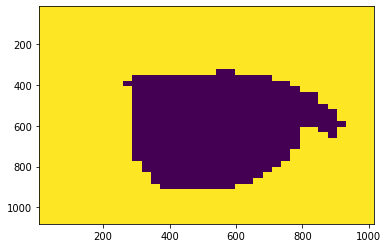

In [19]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )
u, v, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

flags = validation.sig2noise_val(sig2noise, threshold = 1.05 )
u, v = filters.replace_outliers( u, v, flags,
                                  method='localmean', 
                                  max_iter=3, 
                                  kernel_size=3)

# prepare grid mask on the positions marked by the static image masking
# grid_mask = preprocess.prepare_mask_on_grid(x, y, np.array(mask_coords)[:,::-1])
from scipy.ndimage import map_coordinates
grid_mask = map_coordinates(image_mask, [y,x]).astype(bool)

plt.figure()
plt.pcolormesh(x,y,grid_mask)
plt.gca().invert_yaxis()
                                                                        

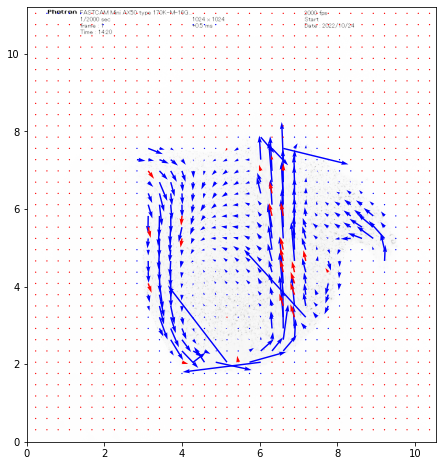

In [20]:
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 ) # 96.52 microns/pixel

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u, v = tools.transform_coordinates(x, y, u, v)

tools.save('exp1_001_mask.txt', x, y, u, v, grid_mask, flags)


fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field('exp1_001_mask.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=50, # scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           image_name='particle image 1.bmp', 
                           show_invalid=True);

In [21]:
from openpiv import windef

In [22]:
settings = windef.PIVSettings()

In [23]:
settings.filepath_images = '.'
settings.frame_pattern_a = 'particle image 1.bmp'
settings.frame_pattern_b = 'particle image 2.bmp'
settings.windowsizes = (32,)
settings.overlap = (16,)
settings.num_iterations = 1
settings.static_masking = True
settings.static_mask = image_mask
settings.sig2noise_threshold = 1.05
settings.show_plot = False
settings.show_all_plots = True

In [24]:
# if you want to review all the settings
# vars(settings)

.
particle image 1.bmp
True
[PosixPath('particle image 1.bmp')]


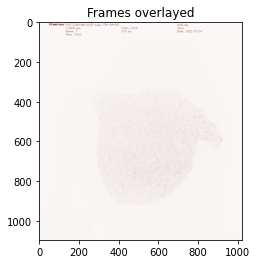

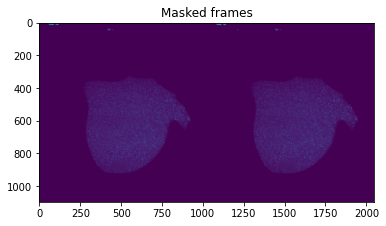

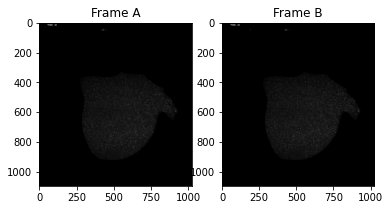

/home/user/Documents/repos/openpiv-python/openpiv/windef.py:312: RuntimeWarning: invalid value encountered in sqrt
  plt.quiver(x, y, u, v, np.sqrt((u**2+v**2)))


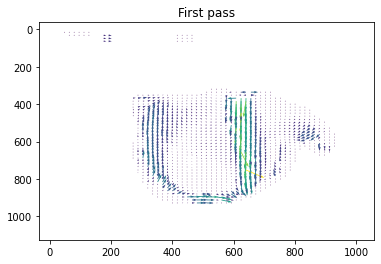

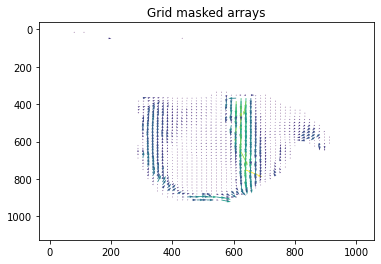

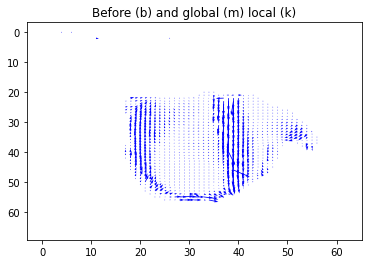

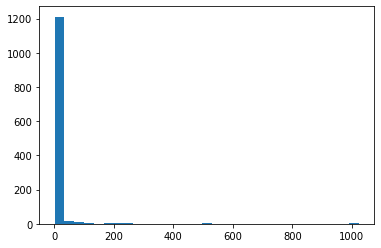

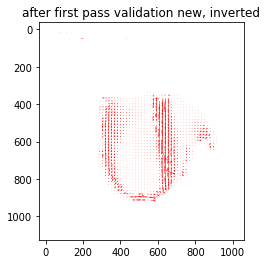

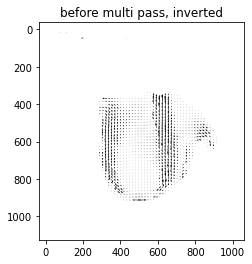

Saving to /home/user/Documents/repos/openpiv-python/openpiv/data/OpenPIV_results_32_test1/field_A0000.txt
Image Pair 1
particle image 1 particle image 2


In [25]:
windef.piv(settings)

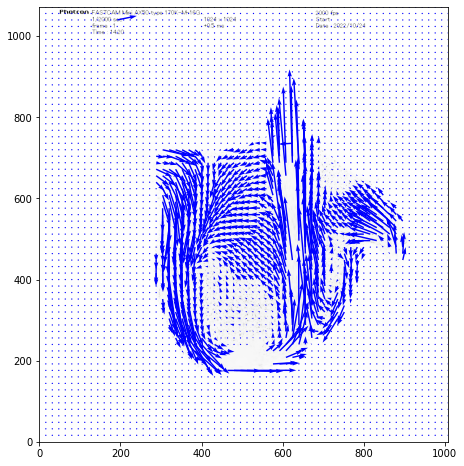

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field(settings.save_path / 'OpenPIV_results_32_test1' / 'field_A0000.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=50, # scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           image_name='particle image 1.bmp', 
                          show_invalid=False);